In [9]:

# 1. Import Libraries

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import json

In [10]:

# 2. Data Preparation

train_dir = r"D:\python for data science\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\train"
val_dir   = r"D:\python for data science\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\val"
test_dir  = r"D:\python for data science\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\test"

#  train Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)


Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


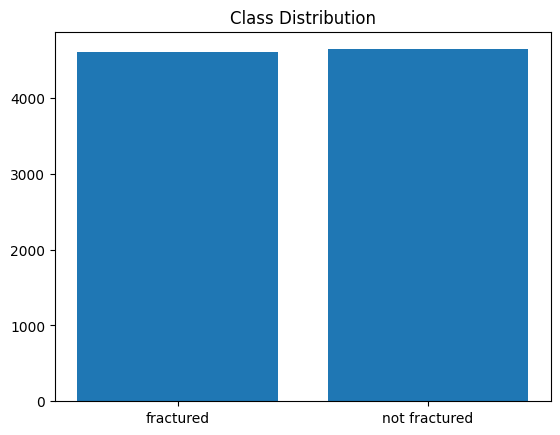

In [11]:


# 3. Class Distribution

labels = list(train_generator.class_indices.keys())
counts = np.bincount(train_generator.classes)

plt.bar(labels, counts)
plt.title("Class Distribution")
plt.show()


In [ ]:

# ========================
# 4. Model Architecture
# ========================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

In [13]:
# ========================
# 5. Callbacks
# ========================
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_bone_fracture.h5", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
]

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


hist = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
289/289 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.7186 - auc: 0.7897

d:\python for data science\.venv\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 [==============================] - 425s 1s/step - loss: 0.6996 - accuracy: 0.7186 - auc: 0.7897 - val_loss: 1.2519 - val_accuracy: 0.4499 - val_auc: 0.5914 - lr: 0.0010
Epoch 2/20
289/289 [==============================] - 200s 692ms/step - loss: 0.4409 - accuracy: 0.8139 - auc: 0.8922 - val_loss: 0.4795 - val_accuracy: 0.8094 - val_auc: 0.8736 - lr: 0.0010
Epoch 3/20
289/289 [==============================] - 207s 716ms/step - loss: 0.3371 - accuracy: 0.8630 - auc: 0.9353 - val_loss: 0.7641 - val_accuracy: 0.8540 - val_auc: 0.9099 - lr: 0.0010
Epoch 4/20
289/289 [==============================] - 206s 714ms/step - loss: 0.3005 - accuracy: 0.8833 - auc: 0.9535 - val_loss: 4.5519 - val_accuracy: 0.4777 - val_auc: 0.6703 - lr: 0.0010
Epoch 5/20
289/289 [==============================] - 207s 717ms/step - loss: 0.2492 - accuracy: 0.9039 - auc: 0.9649 - val_loss: 0.8596 - val_accuracy: 0.7238 - val_auc: 0.8993 - lr: 0.0010
Epoch 6/20
289/289 [==============================] - 211s 

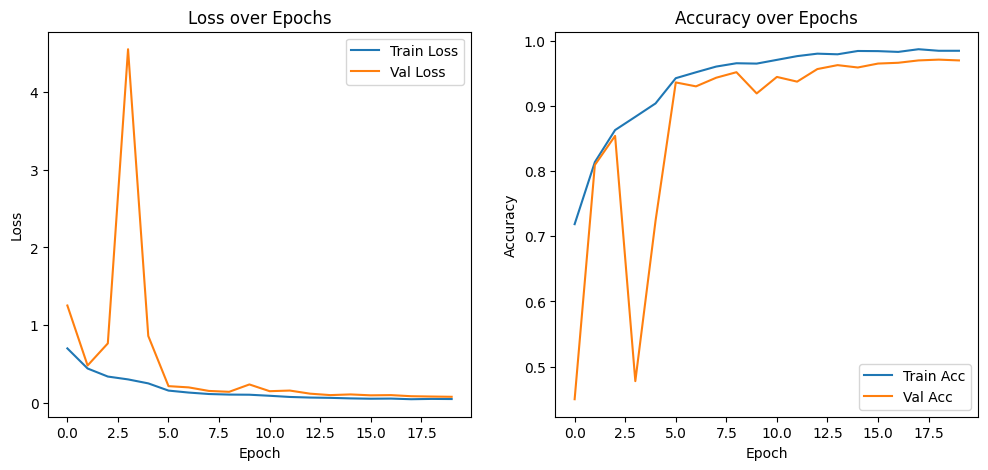

In [16]:
# ========================
# 7. Visualization of Training
# ========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], label='Train Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.show()

In [17]:
# ========================
# 8. Evaluation on Test Data
# ========================
loss, acc, auc_score = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}, AUC: {auc_score:.2f}")

16/16 [==============================] - 11s 715ms/step - loss: 0.1122 - accuracy: 0.9684 - auc: 0.9882
Test Accuracy: 0.97, AUC: 0.99


16/16 [==============================] - 5s 307ms/step

Classification Report:
                precision    recall  f1-score   support

    fractured       0.95      0.98      0.97       238
not fractured       0.98      0.96      0.97       268

     accuracy                           0.97       506
    macro avg       0.97      0.97      0.97       506
 weighted avg       0.97      0.97      0.97       506



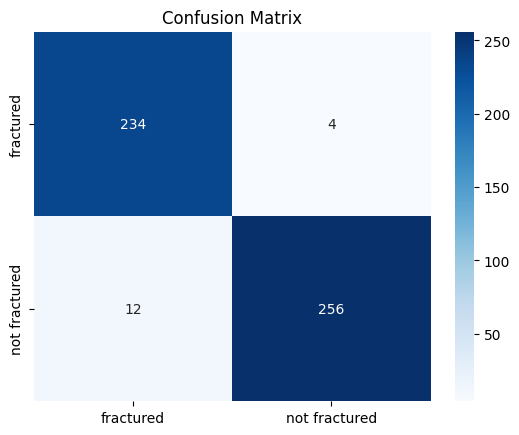

In [18]:
# ========================
# 9. Metrics & Confusion Matrix
# ========================
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32").ravel()

print("\nClassification Report:\n", classification_report(test_generator.classes, y_pred, target_names=labels))

cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.show()

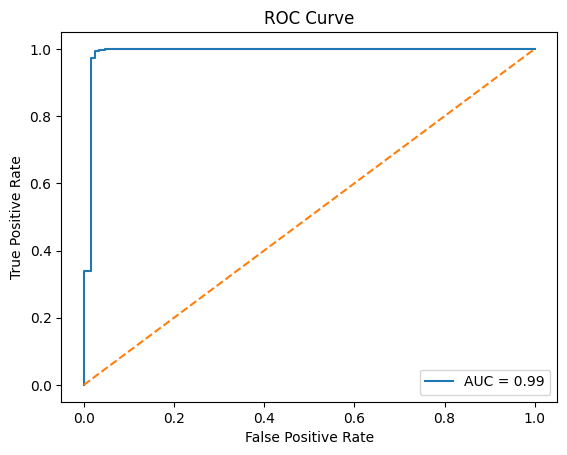

In [19]:
# ========================
# 10. ROC Curve
# ========================
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#For Save The Model

In [20]:
# ========================
# 11. Save Final Model
# ========================
model.save("final_bone_fracture.h5")
print("Model saved as final_bone_fracture.h5")

Model saved as final_bone_fracture.h5
